# Aircraft dynamics

In this example, an IMU is simulated from aircraft dynamics.

The NASA Enginering and Safety Center
[NESC](https://nescacademy.nasa.gov/flightsim/2015) publishes "check-case" data
to compare and validate aircraft dynamics simulators.  Each check-case is a
standardized scenario designed to test simulator performance.  In this example
we use check-case 13.4 (*lateral offset maneuver of a subsonic aircraft*) which
is described in the NESC report, [Reference [31]][references].  Paraphrasing
from the report:

>   This scenario [13.4] utilizes an F-16 model at 10,000 ft above First Flight
airport in Kitty Hawk, NC on a heading of 45 degree true at 400 KTAS relative to
the still atmosphere. The F16 autopilot was engaged. At t = +20.0 sec, a
2,000-ft lateral offset was commanded to the right, and the response of the
vehicle to that command change was recorded.

## Load and visualize the input

First we load and visualize the NESC data.  We see, as described, a right
"dogleg" turn on a trajectory heading north-east.  The aircraft rolls and yaws
to achieve the trajectory change.  Minor deviations in pitch and altitude are
also observed due to the coupled dynamics.

!!! note "Altitude definitions"
    The NESC report defines altitude as *Geometric altitude above reference
    ellipsoid, sphere, or plane* but elsewhere refers to altitude relative to
    mean sea level (MSL) or geoid.  The `GlobalPose` class requires altitude
    relative to the reference ellipsoid.  For the purposes of this example the
    difference is negligible but users should take care to use consistent
    definitions.

In [ ]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# All rights reserved.
# Do not use or redistribute without permission.
# Email: info@inertialsim.com
# -----------------------------------------------------------------------------
%matplotlib widget

import numpy as np

from inertialsim import plot
from inertialsim.examples import nesc

path = "nesc_data"
flight_data = nesc.load(path, "13p4", "02")

lla = plot.MapOverlay("Trajectory", map_type="hybrid", zoom=12)
lla.line(flight_data.position[:, 0], flight_data.position[:, 1])
# Uncomment for real-time interactive visualization
# lla.show()

--8<-- "docs/pages/examples/images/nesc_aircraft_map.html"

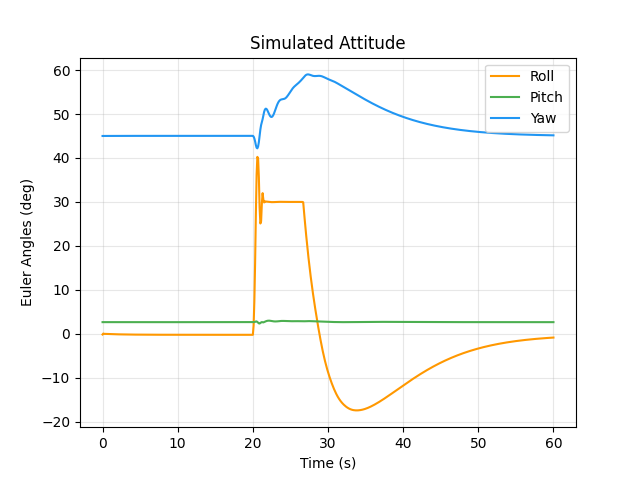

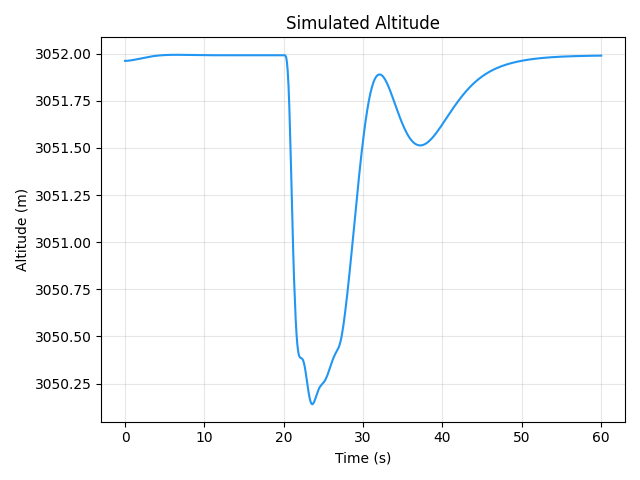

In [2]:
att = plot.TimeSeries(title="Simulated Attitude", ylabel="Euler Angles (deg)")
att.line(flight_data.time, np.rad2deg(flight_data.attitude))
att.legend(["Roll", "Pitch", "Yaw"])

alt = plot.TimeSeries(title="Simulated Altitude", ylabel="Altitude (m)")
alt.line(flight_data.time, flight_data.position[:, 2], color="#2196F3")
alt.figure.set_layout_engine("tight")

## Create the input data

Because the aircraft is flying at 10,000 feet (~3050 meters)
altitude and moving over long distances, we need to use geodetic coordinates
and accurate gravity models.  A local Cartesian frame and/or the assumption that
gravity is fixed and vertical will result in inaccuracies.

We create a [GlobalPose][inertialsim.geodesy.GlobalPose] object and populate it
with the flight data.  Note, we supply both the geodetic position (latitude,
longitude, altitude) and velocity (local-level NED components).  If velocity
data is available, it is highly recommended to use it.  When calculating
accelerometer outputs, a single numerical difference is required from velocity
inputs.  Two numerical differences are required if only position is input.

In [3]:
from inertialsim.geodesy import GlobalPose
from inertialsim.geometry import Rotation

attitude = Rotation.from_euler(flight_data.attitude, "XYZ", flight_data.time)
pose = GlobalPose.from_geodetic(
    attitude=attitude,
    position=flight_data.position,
    velocity=flight_data.velocity,
    time=flight_data.time,
)

## Simulate an aircraft grade IMU measuring the input

Finally we simulate a [Northrop Grumman
LN-200][inertialsim.devices.northrop_grumman_ln200] IMU.  It has a default data
rate of 100Hz.  The NESC flight data is sampled at 10Hz so the input is
resampled in the `simulate` call.  Linear interpolation on the underlying pose
manifold is used.

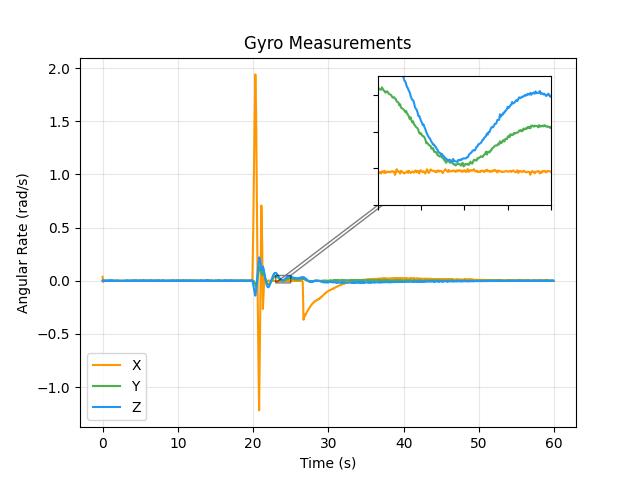

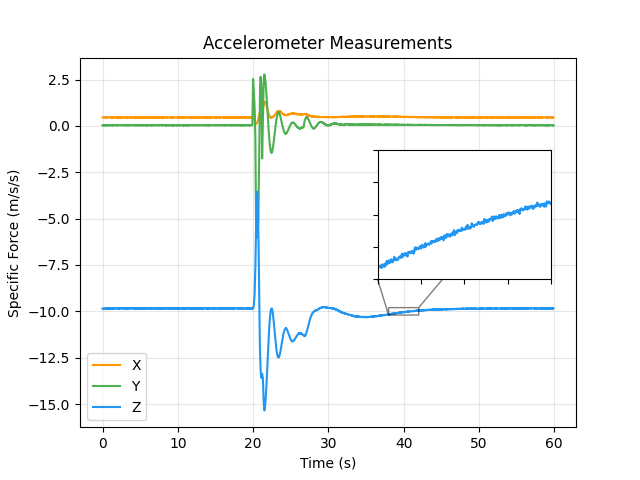

In [4]:
from inertialsim.devices import northrop_grumman_ln200
from inertialsim.sensors.imu import IMU, IMUModel

# Create the IMU and simulate the result.  Using the default IMUModel() ensures
# that the output is resampled to match the LN-200 sample rate.
imu = IMU(IMUModel(), northrop_grumman_ln200, rng=1)
result = imu.simulate(global_pose=pose)

ar = plot.TimeSeries(title="Gyro Measurements", ylabel="Angular Rate (rad/s)")
ar.line(result.angular_rate.time, result.angular_rate.data)
ar.zoom_inset([0.6, 0.6, 0.35, 0.35], [23, 25], [-0.02, 0.05])
ar.legend(["X", "Y", "Z"], loc="lower left")

sf = plot.TimeSeries(
    title="Accelerometer Measurements", ylabel="Specific Force (m/s/s)"
)
sf.line(result.specific_force.time, result.specific_force.data)
sf.zoom_inset([0.6, 0.4, 0.35, 0.35], [38, 42], [-10.2, -9.8])
sf.legend(["X", "Y", "Z"])

## Analyzing the result

Reference angular rate data is available in the NESC data set and it matches the
simulated gyro data closely.  The simulated accelerometer data shows the gravity
vector primarily in the `z-axis` of the sensor frame as expected.  The "dogleg"
maneuver induces an approximately `0.5g` acceleration.  There is a small
nearly-constant component of gravity measured in the `x-axis` of the sensor
frame due to the non-zero pitch angle, which is correlated with the angle of
attack.  This example demonstrates InertialSim's ability to handle geodetic
inputs that accurately account for Earth's shape, rotation, and gravity.